# Análise de Equação Homotópica e Derivada Total

$-\frac{d \tau}{dt} f[x(t)] + [1 - \tau(t)] \frac{\partial f}{\partial x} \frac{dx}{dt} + \frac{d \tau}{dt} g[x(t)] + \tau(t) \frac{\partial g}{\partial x} \frac{dx}{dt} = 0$

Tal que $H(x, \tau) = (1 - \tau)f(x) + \tau(x)$

- Necessito de um problema para encontrar soluções. Testarei com

$g(x) = x^3 -2 x - 5$ aproximada por uma reta $f(x) = x - 3$

In [14]:
# Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [15]:
def psi_homotopy(u, v, T):
    return (1 - T) * np.cos(0.3 * u) + T * np.cos(u)

def Phi(u, v, T):
    x = u
    y = 0.5 * v**2
    z = 0.5 * v**2 * psi_homotopy(u, v, T)
    return x, y, z

In [16]:
u = np.linspace(-4 * np.pi, 4 * np.pi, 200)
v = np.linspace(-2.5, 2.5, 200)
U, V = np.meshgrid(u, v)

# Surface at T = 1.0 (full deformation)
X = U
Y = 0.5 * V**2
Z = 0.5 * V**2 * psi_homotopy(U, V, T=1.0)


<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
C:\Users\pedro\AppData\Local\Temp\ipykernel_14148\854825979.py:5: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title("Surface: $\\Phi(u,v; T=1)$ with $\psi(u,v) = \\cos(u)$")


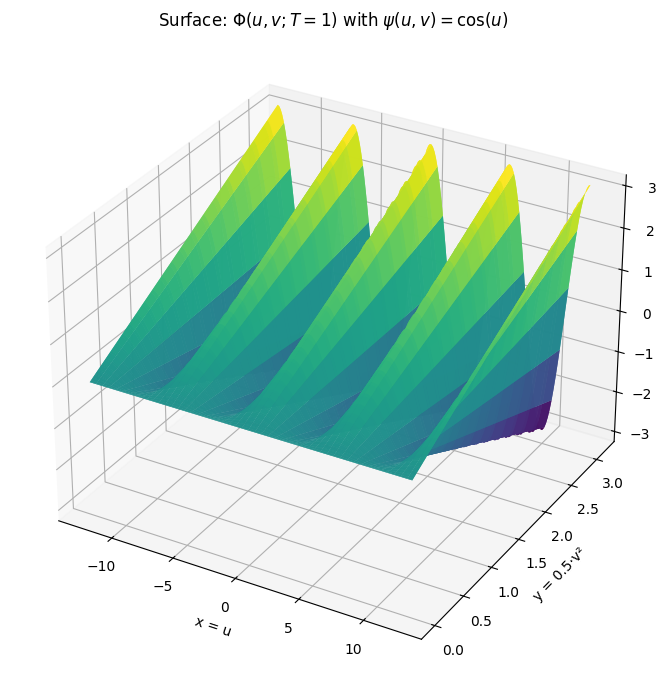

In [17]:
# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_title("Surface: $\\Phi(u,v; T=1)$ with $\psi(u,v) = \\cos(u)$")
ax.set_xlabel('x = u')
ax.set_ylabel('y = 0.5·v²')
ax.set_zlabel('z = 0.5·v²·cos(u)')
plt.tight_layout()
plt.show()

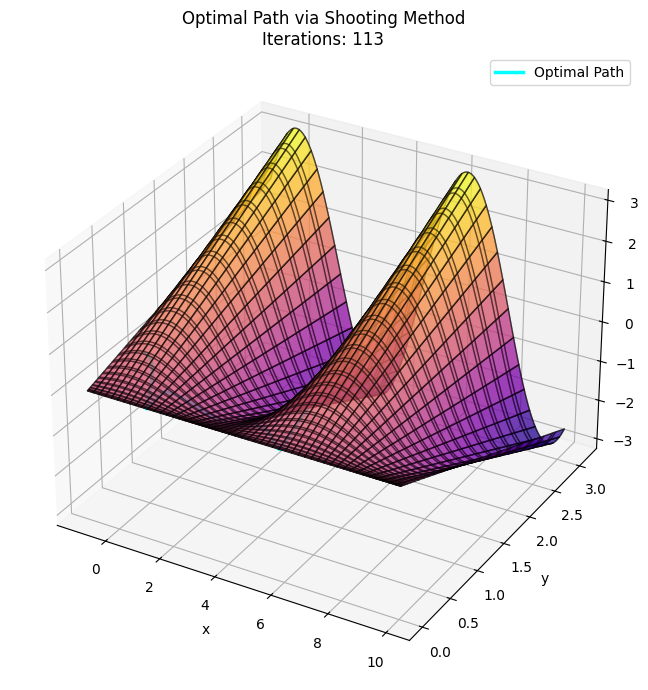

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Surface and Jacobian definitions ---
def psi_homotopy(u, v, T):
    return (1 - T) * np.cos(0.3 * u) + T * np.cos(u)

def Phi(u, v, T):
    x = u
    y = 0.5 * v**2
    z = 0.5 * v**2 * psi_homotopy(u, v, T)
    return np.array([x, y, z])

def finite_diff(f, u, v, h=1e-5):
    f_u_plus = f(u + h, v)
    f_u_minus = f(u - h, v)
    f_v_plus = f(u, v + h)
    f_v_minus = f(u, v - h)
    df_du = (np.array(f_u_plus) - np.array(f_u_minus)) / (2 * h)
    df_dv = (np.array(f_v_plus) - np.array(f_v_minus)) / (2 * h)
    return df_du, df_dv

def compute_jacobian_and_grads(Phi_func, u, v, T):
    def J_local(uu, vv):
        Pu, Pv = finite_diff(lambda a, b: Phi_func(a, b, T), uu, vv)
        return np.linalg.norm(np.cross(Pu, Pv))
    J0 = J_local(u, v)
    dJ_du = (J_local(u + 1e-5, v) - J_local(u - 1e-5, v)) / (2e-5)
    dJ_dv = (J_local(u, v + 1e-5) - J_local(u, v - 1e-5)) / (2e-5)
    return J0, dJ_du, dJ_dv

# --- Euler–Lagrange integration with homotopy and Jacobian potential ---
def integrate_path(u0, v0, du0, dv0, T, n_steps=200, h=0.01, λ=1.0, k=2):
    u_vals = np.zeros(n_steps)
    v_vals = np.zeros(n_steps)
    du_vals = np.zeros(n_steps)
    dv_vals = np.zeros(n_steps)
    u_vals[0], v_vals[0] = u0, v0
    du_vals[0], dv_vals[0] = du0, dv0
    for i in range(n_steps - 1):
        u, v = u_vals[i], v_vals[i]
        du, dv = du_vals[i], dv_vals[i]
        J, dJ_du, dJ_dv = compute_jacobian_and_grads(Phi, u, v, T)
        if J < 1e-6: J = 1e-6
        dd_u = -λ * k * dJ_du / J**(k + 1)
        dd_v = -λ * k * dJ_dv / J**(k + 1)
        du_next = du + h * dd_u
        dv_next = dv + h * dd_v
        u_next = u + h * du
        v_next = v + h * dv
        u_vals[i+1] = u_next
        v_vals[i+1] = v_next
        du_vals[i+1] = du_next
        dv_vals[i+1] = dv_next
    return u_vals, v_vals

# --- Shooting method optimizer ---
iteration_counter = {'count': 0}
def objective(initial_velocity, u0, v0, u_target, v_target, T):
    iteration_counter['count'] += 1
    du0, dv0 = initial_velocity
    u_path, v_path = integrate_path(u0, v0, du0, dv0, T)
    u_end, v_end = u_path[-1], v_path[-1]
    error = np.sqrt((u_end - u_target)**2 + (v_end - v_target)**2)
    return error

# --- Define endpoints and optimize ---
u0, v0 = 0.0, 1.0
u_target, v_target = 8.0, 1.0
T = 1.0

res = minimize(objective, x0=[1.0, 0.0], args=(u0, v0, u_target, v_target, T),
               method='Nelder-Mead', options={'maxiter': 200, 'xatol': 1e-3, 'fatol': 1e-3})

optimal_du0, optimal_dv0 = res.x
u_path, v_path = integrate_path(u0, v0, optimal_du0, optimal_dv0, T)

# --- Map to surface ---
x_path, y_path, z_path = [], [], []
for u, v in zip(u_path, v_path):
    x, y, z = Phi(u, v, T)
    x_path.append(x)
    y_path.append(y)
    z_path.append(z)

# --- Plot result ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
U, V = np.meshgrid(np.linspace(-1, 10, 200), np.linspace(-2.5, 2.5, 200))
Y = 0.5 * V**2
Z = 0.5 * V**2 * psi_homotopy(U, V, T=1.0)
ax.plot_surface(U, Y, Z, cmap='plasma', alpha=0.5, edgecolor='k')
ax.plot3D(x_path, y_path, z_path, color='cyan', linewidth=2.5, label='Optimal Path')
ax.set_title(f'Optimal Path via Shooting Method\nIterations: {iteration_counter["count"]}')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.tight_layout()
plt.show()


C:\Users\pedro\AppData\Local\Temp\ipykernel_14148\200400627.py:7: RuntimeWarning: overflow encountered in scalar power
  f1 = y**2 + x   # função original
C:\Users\pedro\AppData\Local\Temp\ipykernel_14148\200400627.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  return (1 - lam)*f0 + lam*f1


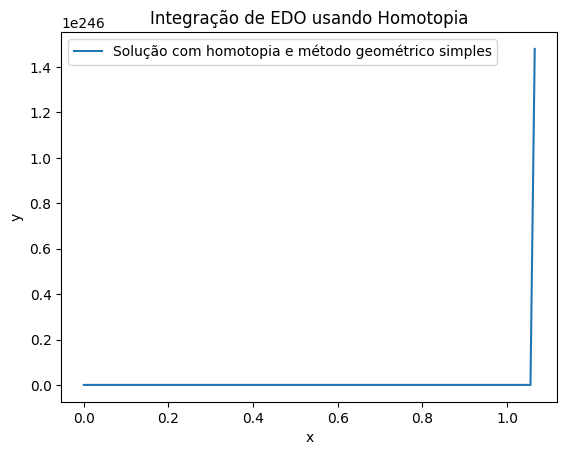

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Definição da homotopia f(y,x,lambda)
def f(y, x, lam):
    f0 = y          # função simples
    f1 = y**2 + x   # função original
    return (1 - lam)*f0 + lam*f1

# Parâmetros
x0, y0 = 0.0, 1.0
xf = 2.0
Nx = 200
Nlam = 50

x = np.linspace(x0, xf, Nx)
lam_values = np.linspace(0, 1, Nlam)

# Inicializar solução
y = np.zeros(Nx)
y[:] = y0

# Integração por homotopia
for lam in lam_values:
    # Método de Euler simples com passo dx para ilustrar
    dx = (xf - x0) / (Nx - 1)
    y_new = np.zeros_like(y)
    y_new[0] = y0
    for i in range(1, Nx):
        k1 = f(y_new[i-1], x[i-1], lam)
        y_new[i] = y_new[i-1] + k1*dx
    y = y_new

plt.plot(x, y, label='Solução com homotopia e método geométrico simples')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Integração de EDO usando Homotopia')
plt.show()


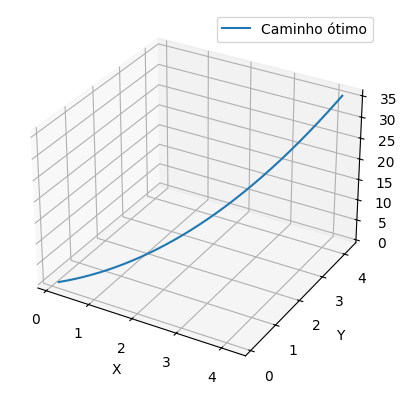

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do problema
alpha = 1.0
k = 2

# Parametrização da superfície r(u,v)
def r(u, v):
    # Exemplo: superfície paraboloide
    x = u
    y = v
    z = u**2 + v**2
    return np.array([x, y, z])

# Derivadas parciais para Jacobiano
def dr_du(u, v):
    return np.array([1, 0, 2*u])

def dr_dv(u, v):
    return np.array([0, 1, 2*v])

def J(u, v):
    cross = np.cross(dr_du(u,v), dr_dv(u,v))
    return np.linalg.norm(cross)

# Gradiente do potencial V = alpha / J^k em (u,v)
def grad_V(u, v):
    eps = 1e-6  # para evitar divisão por zero
    J_val = J(u,v) + eps
    V = alpha / (J_val ** k)
    
    # Derivar numericamente gradiente
    h = 1e-5
    dV_du = (alpha / ( (J(u+h, v) + eps) ** k ) - V) / h
    dV_dv = (alpha / ( (J(u, v+h) + eps) ** k ) - V) / h
    
    return np.array([dV_du, dV_dv])

# Integração numérica (Euler) com homotopia em lambda
def integrate_path(u0, v0, du0, dv0, t_max, dt):
    N = int(t_max / dt)
    u = np.zeros(N)
    v = np.zeros(N)
    du = np.zeros(N)
    dv = np.zeros(N)
    
    u[0], v[0] = u0, v0
    du[0], dv[0] = du0, dv0
    
    lam_values = np.linspace(0, 1, 100)
    
    for lam in lam_values:
        for i in range(1, N):
            grad = grad_V(u[i-1], v[i-1])
            # Equação de movimento com homotopia
            d2u = -lam * grad[0]
            d2v = -lam * grad[1]
            
            # Euler para velocidade
            du[i] = du[i-1] + d2u * dt
            dv[i] = dv[i-1] + d2v * dt
            
            # Euler para posição
            u[i] = u[i-1] + du[i] * dt
            v[i] = v[i-1] + dv[i] * dt
    
    return u, v

# Condições iniciais
u0, v0 = 0.1, 0.1
du0, dv0 = 0.0, 0.0
t_max = 5
dt = 0.01

u_path, v_path = integrate_path(u0, v0, du0, dv0, t_max, dt)

# Obter pontos 3D na superfície
points_3d = np.array([r(u_path[i], v_path[i]) for i in range(len(u_path))])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(points_3d[:,0], points_3d[:,1], points_3d[:,2], label='Caminho ótimo')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()


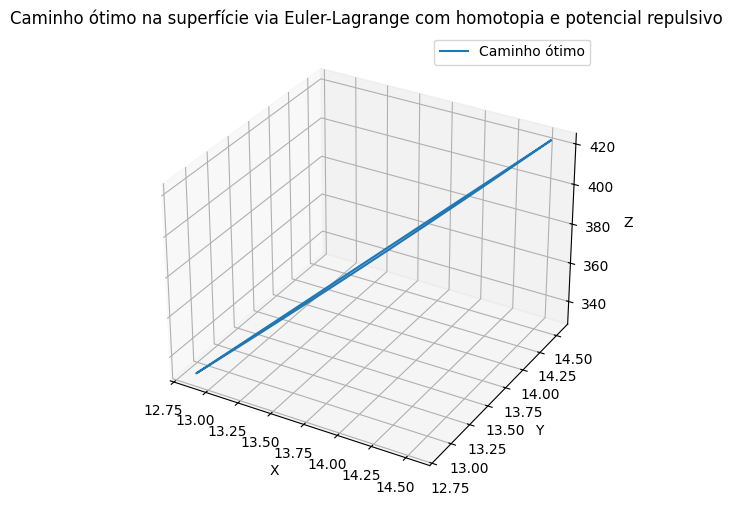

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do problema
alpha = 1.0  # força do potencial repulsivo
k = 2        # potência do Jacobiano no denominador
h_fd = 1e-5  # passo para diferenças finitas

# Parametrização da superfície (exemplo paraboloide)
def r(u, v):
    x = u
    y = v
    z = u**2 + v**2
    return np.array([x, y, z])

# Cálculo do Jacobiano via diferenças finitas centradas
def J_fd(u, v, h=h_fd):
    r_u_plus = r(u + h, v)
    r_u_minus = r(u - h, v)
    r_v_plus = r(u, v + h)
    r_v_minus = r(u, v - h)
    
    dr_du = (r_u_plus - r_u_minus) / (2*h)
    dr_dv = (r_v_plus - r_v_minus) / (2*h)
    
    cross = np.cross(dr_du, dr_dv)
    return np.linalg.norm(cross)

# Gradiente do potencial V = alpha / J^k via diferenças finitas
def grad_V(u, v):
    eps = 1e-8  # para evitar divisão por zero
    J_val = J_fd(u, v) + eps
    V = alpha / (J_val ** k)
    
    # gradientes por diferenças finitas
    du = h_fd
    dv = h_fd
    
    V_u_plus = alpha / ((J_fd(u + du, v) + eps) ** k)
    V_v_plus = alpha / ((J_fd(u, v + dv) + eps) ** k)
    
    dV_du = (V_u_plus - V) / du
    dV_dv = (V_v_plus - V) / dv
    
    return np.array([dV_du, dV_dv])

# Integração da equação de movimento com homotopia
def integrate_path(u0, v0, du0, dv0, t_max, dt, n_homotopy_steps):
    N = int(t_max / dt)
    u = np.zeros(N)
    v = np.zeros(N)
    du = np.zeros(N)
    dv = np.zeros(N)
    
    u[0], v[0] = u0, v0
    du[0], dv[0] = du0, dv0
    
    lam_values = np.linspace(0, 1, n_homotopy_steps)
    
    for lam in lam_values:
        for i in range(1, N):
            grad = grad_V(u[i-1], v[i-1])
            # Equação de Euler-Lagrange com homotopia
            d2u = -lam * grad[0]
            d2v = -lam * grad[1]
            
            # Atualiza velocidades
            du[i] = du[i-1] + d2u * dt
            dv[i] = dv[i-1] + d2v * dt
            
            # Atualiza posições
            u[i] = u[i-1] + du[i] * dt
            v[i] = v[i-1] + dv[i] * dt
            
        # A cada passo da homotopia, reinicia velocidades para continuar deformando suavemente
        du[0], dv[0] = du[-1], dv[-1]
        u[0], v[0] = u[-1], v[-1]
    
    return u, v

# Condições iniciais e parâmetros
u0, v0 = 0.1, 0.1
du0, dv0 = 0.0, 0.0
t_max = 5.0
dt = 0.01
n_homotopy_steps = 10

# Executa integração
u_path, v_path = integrate_path(u0, v0, du0, dv0, t_max, dt, n_homotopy_steps)

# Mapeia para 3D na superfície
points_3d = np.array([r(u_path[i], v_path[i]) for i in range(len(u_path))])

# Plot
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(points_3d[:,0], points_3d[:,1], points_3d[:,2], label='Caminho ótimo')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Caminho ótimo na superfície via Euler-Lagrange com homotopia e potencial repulsivo')
ax.legend()
plt.show()


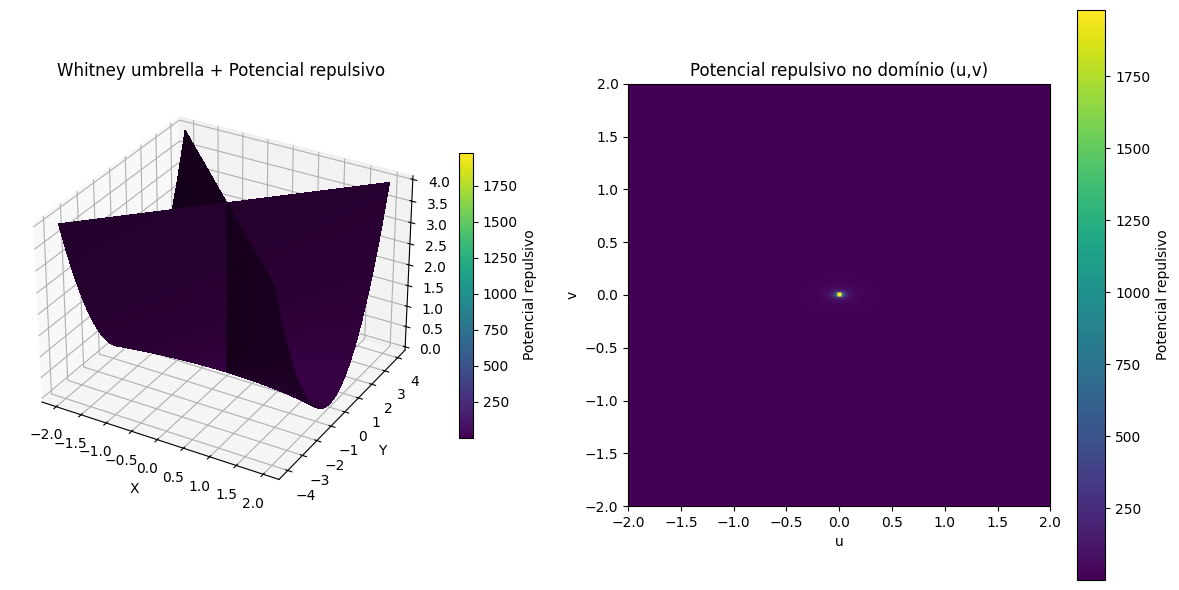

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parâmetros do potencial repulsivo
alpha = 1.0
k = 2
h_fd = 1e-5

# Whitney umbrella
def r(u, v):
    x = u
    y = u * v
    z = v**2
    return np.array([x, y, z])

def J_fd(u, v, h=h_fd):
    r_u_plus = r(u + h, v)
    r_u_minus = r(u - h, v)
    r_v_plus = r(u, v + h)
    r_v_minus = r(u, v - h)
    
    dr_du = (r_u_plus - r_u_minus) / (2*h)
    dr_dv = (r_v_plus - r_v_minus) / (2*h)
    
    cross = np.cross(dr_du, dr_dv)
    return np.linalg.norm(cross)

# Domínio paramétrico
u_vals = np.linspace(-2, 2, 200)
v_vals = np.linspace(-2, 2, 200)
U, V = np.meshgrid(u_vals, v_vals)

# Calcula pontos 3D
X = np.zeros(U.shape)
Y = np.zeros(U.shape)
Z = np.zeros(U.shape)
V_pot = np.zeros(U.shape)

eps = 1e-8
for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        u = U[i, j]
        v = V[i, j]
        pt = r(u, v)
        X[i, j] = pt[0]
        Y[i, j] = pt[1]
        Z[i, j] = pt[2]
        J = J_fd(u, v) + eps
        V_pot[i, j] = alpha / (J ** k)

# Plot da superfície com coloração do potencial
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, facecolors=plt.cm.viridis(V_pot / np.max(V_pot)), rstride=1, cstride=1, linewidth=0, antialiased=False)
ax1.set_title('Whitney umbrella + Potencial repulsivo')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

m = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
m.set_array(V_pot)
fig.colorbar(m, ax=ax1, shrink=0.5, label='Potencial repulsivo')

# Plot do potencial repulsivo no domínio paramétrico (u,v)
ax2 = fig.add_subplot(122)
im = ax2.imshow(V_pot, extent=[u_vals.min(), u_vals.max(), v_vals.min(), v_vals.max()], origin='lower', cmap='viridis')
ax2.set_title('Potencial repulsivo no domínio (u,v)')
ax2.set_xlabel('u')
ax2.set_ylabel('v')
fig.colorbar(im, ax=ax2, label='Potencial repulsivo')

plt.tight_layout()
plt.show()


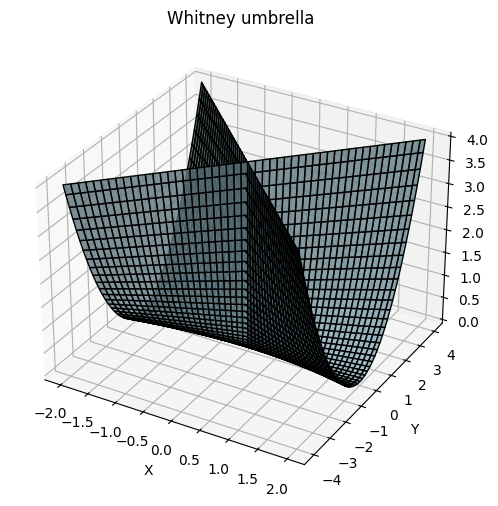

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parametrização Whitney umbrella
def r(u, v):
    x = u
    y = u * v
    z = v**2
    return np.array([x, y, z])

# Domínio paramétrico
u_vals = np.linspace(-2, 2, 200)
v_vals = np.linspace(-2, 2, 200)
U, V = np.meshgrid(u_vals, v_vals)

# Calcula pontos 3D
X = np.zeros(U.shape)
Y = np.zeros(U.shape)
Z = np.zeros(U.shape)

for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        pt = r(U[i, j], V[i, j])
        X[i, j], Y[i, j], Z[i, j] = pt

# Plot superfície
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, color='lightblue', edgecolor='k', alpha=0.8)
ax.set_title('Whitney umbrella')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


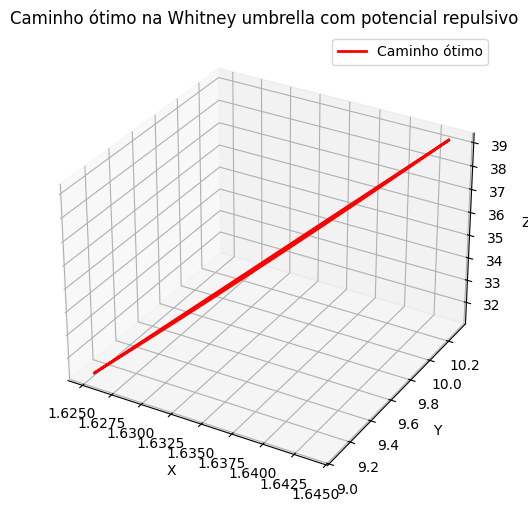

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
alpha = 1.0
k = 2
h_fd = 1e-5

# Superfície Whitney umbrella
def r(u, v):
    x = u
    y = u * v
    z = v**2
    return np.array([x, y, z])

# Jacobiano via diferenças finitas centradas
def J_fd(u, v, h=h_fd):
    r_u_plus = r(u + h, v)
    r_u_minus = r(u - h, v)
    r_v_plus = r(u, v + h)
    r_v_minus = r(u, v - h)
    
    dr_du = (r_u_plus - r_u_minus) / (2*h)
    dr_dv = (r_v_plus - r_v_minus) / (2*h)
    
    cross = np.cross(dr_du, dr_dv)
    return np.linalg.norm(cross)

# Gradiente do potencial V = alpha / J^k
def grad_V(u, v):
    eps = 1e-8  # evitar divisão por zero
    J_val = J_fd(u, v) + eps
    V = alpha / (J_val ** k)
    
    du = h_fd
    dv = h_fd
    
    V_u_plus = alpha / ((J_fd(u + du, v) + eps) ** k)
    V_v_plus = alpha / ((J_fd(u, v + dv) + eps) ** k)
    
    dV_du = (V_u_plus - V) / du
    dV_dv = (V_v_plus - V) / dv
    
    return np.array([dV_du, dV_dv])

# Integração do caminho com homotopia
def integrate_path(u0, v0, du0, dv0, t_max, dt, n_homotopy_steps):
    N = int(t_max / dt)
    u = np.zeros(N)
    v = np.zeros(N)
    du = np.zeros(N)
    dv = np.zeros(N)
    
    u[0], v[0] = u0, v0
    du[0], dv[0] = du0, dv0
    
    lam_values = np.linspace(0, 1, n_homotopy_steps)
    
    for lam in lam_values:
        for i in range(1, N):
            grad = grad_V(u[i-1], v[i-1])
            # Euler-Lagrange com homotopia
            d2u = -lam * grad[0]
            d2v = -lam * grad[1]
            
            du[i] = du[i-1] + d2u * dt
            dv[i] = dv[i-1] + d2v * dt
            
            u[i] = u[i-1] + du[i] * dt
            v[i] = v[i-1] + dv[i] * dt
        
        # Reinicia condições para próxima homotopia
        du[0], dv[0] = du[-1], dv[-1]
        u[0], v[0] = u[-1], v[-1]
    
    return u, v

# Condições iniciais e parâmetros
u0, v0 = 1.5, 1.5
du0, dv0 = 0.0, 0.0
t_max = 5.0
dt = 0.01
n_homotopy_steps = 10

# Calcula caminho
u_path, v_path = integrate_path(u0, v0, du0, dv0, t_max, dt, n_homotopy_steps)

# Mapeia caminho para 3D
points_3d = np.array([r(u_path[i], v_path[i]) for i in range(len(u_path))])

# Plot resultado
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(points_3d[:,0], points_3d[:,1], points_3d[:,2], label='Caminho ótimo', color='red', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Caminho ótimo na Whitney umbrella com potencial repulsivo')
ax.legend()
plt.show()


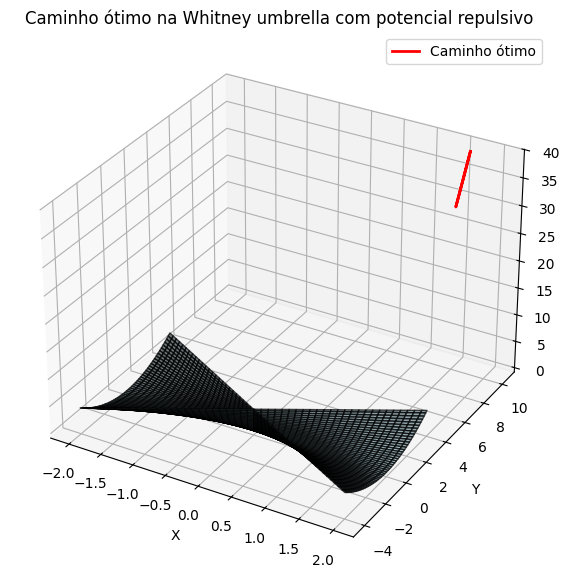

Número total de iterações: 4990


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros
alpha = 1.0
k = 2
h_fd = 1e-5

# Superfície Whitney umbrella
def r(u, v):
    x = u
    y = u * v
    z = v**2
    return np.array([x, y, z])

# Jacobiano via diferenças finitas centradas
def J_fd(u, v, h=h_fd):
    r_u_plus = r(u + h, v)
    r_u_minus = r(u - h, v)
    r_v_plus = r(u, v + h)
    r_v_minus = r(u, v - h)
    
    dr_du = (r_u_plus - r_u_minus) / (2*h)
    dr_dv = (r_v_plus - r_v_minus) / (2*h)
    
    cross = np.cross(dr_du, dr_dv)
    return np.linalg.norm(cross)

# Gradiente do potencial V = alpha / J^k
def grad_V(u, v):
    eps = 1e-8  # evitar divisão por zero
    J_val = J_fd(u, v) + eps
    V = alpha / (J_val ** k)
    
    du = h_fd
    dv = h_fd
    
    V_u_plus = alpha / ((J_fd(u + du, v) + eps) ** k)
    V_v_plus = alpha / ((J_fd(u, v + dv) + eps) ** k)
    
    dV_du = (V_u_plus - V) / du
    dV_dv = (V_v_plus - V) / dv
    
    return np.array([dV_du, dV_dv])

# Integração do caminho com homotopia
def integrate_path(u0, v0, du0, dv0, t_max, dt, n_homotopy_steps):
    N = int(t_max / dt)
    u = np.zeros(N)
    v = np.zeros(N)
    du = np.zeros(N)
    dv = np.zeros(N)
    
    u[0], v[0] = u0, v0
    du[0], dv[0] = du0, dv0
    
    lam_values = np.linspace(0, 1, n_homotopy_steps)
    
    total_iterations = 0
    
    for lam in lam_values:
        for i in range(1, N):
            grad = grad_V(u[i-1], v[i-1])
            # Euler-Lagrange com homotopia
            d2u = -lam * grad[0]
            d2v = -lam * grad[1]
            
            du[i] = du[i-1] + d2u * dt
            dv[i] = dv[i-1] + d2v * dt
            
            u[i] = u[i-1] + du[i] * dt
            v[i] = v[i-1] + dv[i] * dt
            
            total_iterations += 1
        
        # Reinicia condições para próxima homotopia
        du[0], dv[0] = du[-1], dv[-1]
        u[0], v[0] = u[-1], v[-1]
    
    return u, v, total_iterations

# Condições iniciais e parâmetros
u0, v0 = 1.5, 1.5
du0, dv0 = 0.0, 0.0
t_max = 5.0
dt = 0.01
n_homotopy_steps = 10

# Calcula caminho
u_path, v_path, total_iters = integrate_path(u0, v0, du0, dv0, t_max, dt, n_homotopy_steps)

# Mapeia caminho para 3D
points_3d = np.array([r(u_path[i], v_path[i]) for i in range(len(u_path))])

# Domínio paramétrico para plot da superfície
u_vals = np.linspace(-2, 2, 200)
v_vals = np.linspace(-2, 2, 200)
U, V = np.meshgrid(u_vals, v_vals)
X = np.zeros(U.shape)
Y = np.zeros(U.shape)
Z = np.zeros(U.shape)

for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        pt = r(U[i, j], V[i, j])
        X[i, j], Y[i, j], Z[i, j] = pt

# Plot superfície + caminho
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, color='lightblue', alpha=0.7, edgecolor='k')
ax.plot(points_3d[:,0], points_3d[:,1], points_3d[:,2], color='red', linewidth=2, label='Caminho ótimo')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Caminho ótimo na Whitney umbrella com potencial repulsivo')
ax.legend()
plt.show()

print(f'Número total de iterações: {total_iters}')
